# 趋势跟踪策略

## 常见趋势指标的回测

注意事项：
- 首先，对依赖的交易信号进行历史回测是投资中最重要的环节，没有之一。历史回测相当于对一种投资想法进行高强度的验证。通过分析回测结果，可以在使用这些交易信号进行实盘投资之前，对它们各自的投资效果和细微差异有客观的了解，达到“去伪存真”的目的。

- 在做回测时，要避免引入未来数据。在每一个历史时点上生成当时的交易信号时，一定要屏蔽掉那个时点之后的数据。



In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shared.tools import get_drawdown, cal_period_perf_indicator, datestr2dtdate, date_count_in_month

In [2]:
def backtest_result(df, title):
    ret_df = df.loc[:, ['asset', 'stgy']]

    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(2, 1, 1)
    ret_df.plot(ax=ax1, grid=True, title=title)
    ax2 = fig.add_subplot(2, 1, 2)
    df.loc[:, ['pos']].plot(ax=ax2, grid=True)

    res = cal_period_perf_indicator(ret_df)
    res['TotalRet'] = ret_df.iloc[-1, :] - 1
    print(res)

In [3]:
# index_data = pd.read_csv('./res/指数历史数据.csv').set_index('datetime')
index_data = pd.read_csv('./res/main-indices-data.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2022, 12, 31)
index_id = 'csi1000'

### 近期涨幅的回测

回看天数 N=20，根据回看期上的涨幅决定交易方向，看多阈值 long_threshold=0.05，看空阈值 short_threshold=-0.05。
选取参数后，在沪深 300 指数上进行回测。因为普通投资者不太容易做空沪深 300 指数，所以回测中仓位的规则是：当指标看多时满仓，当指标看空时空仓，其它时间半仓。


In [4]:
N = 22
long_threshold = 0.05
short_threshold = -0.05

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
asset  0.047768  0.237842  0.200838 -0.346243   0.13796  0.148484
stgy   0.056345  0.136152  0.413837 -0.153611  0.366801  0.176604


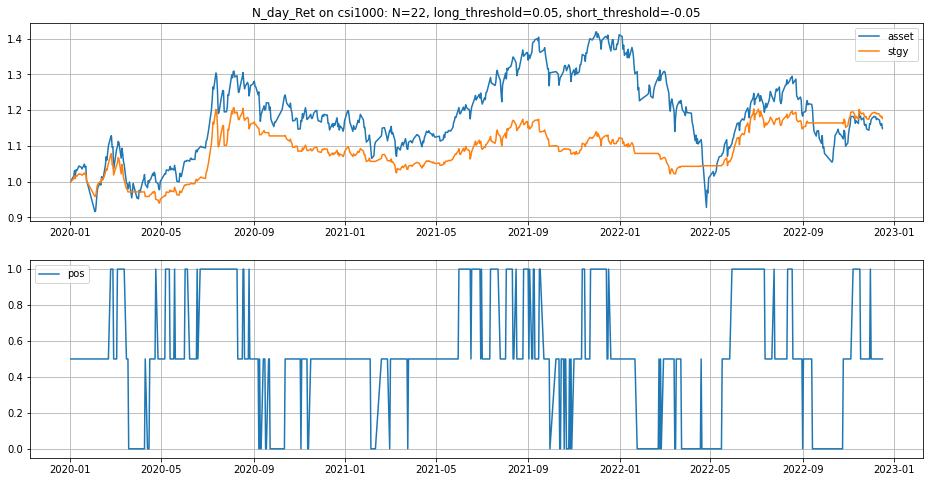

In [5]:
df = index_data.loc[start_date:end_date, [index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1 + df['ret']).cumprod().fillna(1)
df['N_day_ret'] = df['asset'] / df['asset'].shift(N) - 1
df['pos'] = [1 if e > long_threshold else 0 if e < short_threshold else 0.5 for e in df['N_day_ret'].shift(1)]
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1 + df['stgy_ret']).cumprod().fillna(1)

backtest_result(df,
                title='N_day_Ret on %s: N=%d, long_threshold=%.2f, short_threshold=%.2f' %
                (index_id, N, long_threshold, short_threshold))


### 双均线系统的回测

短均线回看天数 N1=10，长均线回看天数 N2=60，根据短均线与长均线的比值决定交易方向，看多阈值 1.05，看空阈值 0.95。
选取参数后，在沪深 300 指数上进行回测，决定仓位的规则：当指标看多时满仓，当指标看空时空仓，其他时间半仓。

结果：
显著改善了对沪深 300 的长期投资效果。而且它的好处在于，仓位调整的频率比近期涨幅指标要低很多，大致平均每两个月才调整一次，个人投资者可以比较轻松地实施。


In [6]:
N1 = 22
N2 = 55
long_threshold = 1.05
short_threshold = 0.95

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
asset  0.047768  0.237842  0.200838 -0.346243   0.13796  0.148484
stgy  -0.011705  0.131644 -0.088916  -0.20268 -0.057752 -0.034331


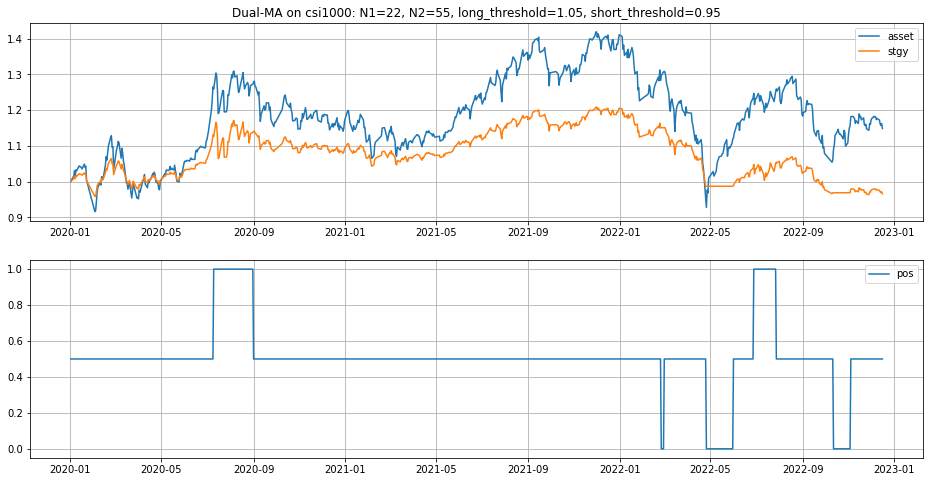

In [7]:
df = index_data.loc[start_date:end_date, [index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df['ret'] = df['asset'].pct_change()
df['MA1'] = df['asset'].rolling(window=N1).mean()
df['MA2'] = df['asset'].rolling(window=N2).mean()
df['MA1/MA2'] = df['MA1'] / df['MA2']
df['pos'] = [1 if e>long_threshold else 0 if e<short_threshold else 0.5 for e in df['MA1/MA2'].shift(1)]

df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

backtest_result(df,
                title='Dual-MA on %s: N1=%d, N2=%d, long_threshold=%.2f, short_threshold=%.2f' %
                (index_id, N1, N2, long_threshold, short_threshold))

### 布林带的回测

选取的参数是回看天数 N=20，同样在沪深 300 指数上进行回测，决定仓位的规则还是一样的：当指标看多时满仓，当指标看空时空仓，其他时间半仓。


典型的趋势跟踪策略的特点是“半年不开张，开张吃半年”。

建议个人投资者慎入“高度内卷”的短线趋势策略赛道，重点关注中长期趋势跟踪策略。

In [8]:
N = 21


         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
asset  0.047768  0.237842  0.200838 -0.346243   0.13796  0.148484
stgy   0.052755  0.118627  0.444714 -0.180638  0.292049  0.164781


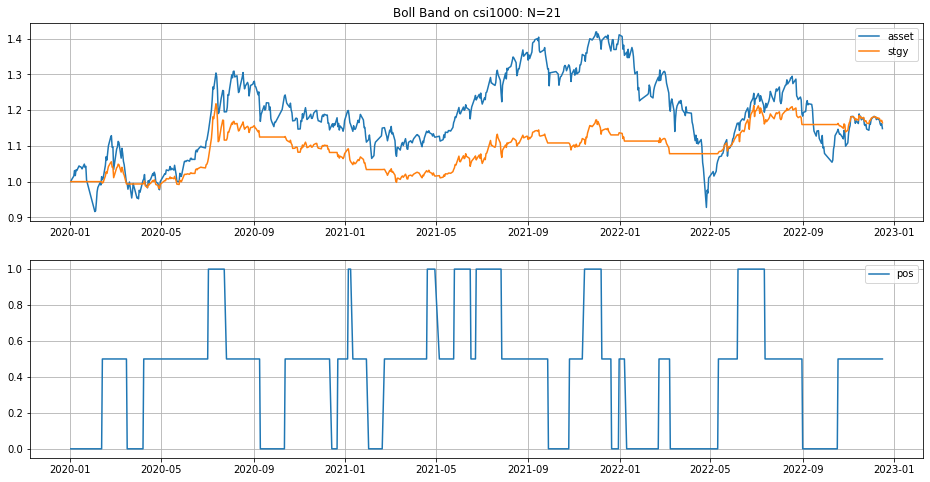

In [9]:
df = index_data.loc[start_date:end_date, [index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1 + df['ret']).cumprod().fillna(1)
df['ret'] = df['asset'].pct_change()
df['MA'] = df['asset'].rolling(window=N).mean()
df['std'] = df['asset'].rolling(window=N).std()
df['up'] = df['MA'] + 2 * df['std']
df['down'] = df['MA'] - 2 * df['std']

df['pos'] = 0
for i in range(1, len(df)):
    t = df.index[i]
    t0 = df.index[i - 1]
    if df.loc[t0, 'asset'] > df.loc[t0, 'up']:
        df.loc[t, 'pos'] = 1
    elif df.loc[t0, 'asset'] < df.loc[t0, 'down']:
        df.loc[t, 'pos'] = 0
    elif df.loc[t0, 'pos'] == 1 and df.loc[t0, 'asset'] < df.loc[t0, 'MA']:
        df.loc[t, 'pos'] = 0.5
    elif df.loc[t0, 'pos'] == 0 and df.loc[t0, 'asset'] > df.loc[t0, 'MA']:
        df.loc[t, 'pos'] = 0.5
    else:
        df.loc[t, 'pos'] = df.loc[t0, 'pos']

df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1 + df['stgy_ret']).cumprod().fillna(1)

backtest_result(df, title='Boll Band on %s: N=%d' % (index_id, N))

可做空

           AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
csi1000  0.047768  0.237842  0.200838 -0.346243   0.13796  0.148484
stgy     -0.00205  0.157822 -0.012987  -0.27907 -0.007345 -0.006069


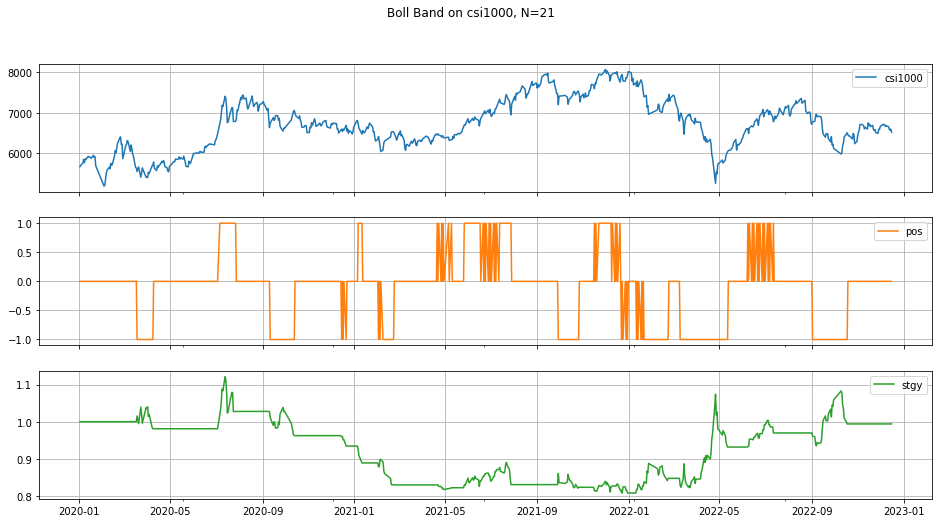

In [12]:
df = index_data.loc[start_date:end_date, [index_id]]

df['ret'] = df[index_id].pct_change()
df['MA'] = df[index_id].rolling(window=N).mean()
df['std'] = df[index_id].rolling(window=N).std()
df['up'] = df['MA'] + 2 * df['std']
df['down'] = df['MA'] - 2 * df['std']

df['pos'] = 0
for i in range(2, len(df)):
    t = df.index[i]
    t0 = df.index[i - 2]
    if df.loc[t0, index_id] > df.loc[t0, 'up']:
        df.loc[t, 'pos'] = 1
    elif df.loc[t0, index_id] < df.loc[t0, 'down']:
        df.loc[t, 'pos'] = -1
    elif df.loc[t0, 'pos'] == 1 and df.loc[t0, index_id] < df.loc[t0, 'MA']:
        df.loc[t, 'pos'] = 0
    elif df.loc[t0, 'pos'] == -1 and df.loc[t0, index_id] > df.loc[t0, 'MA']:
        df.loc[t, 'pos'] = 0
    else:
        df.loc[t, 'pos'] = df.loc[t0, 'pos']

df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1 + df['stgy_ret']).cumprod().fillna(1)

df.loc[:, [index_id, 'pos', 'stgy']].plot(figsize=(16, 8),
                                          subplots=True,
                                          grid=True,
                                          title='Boll Band on %s, N=%d' % (index_id, N))

value_df = df.loc[:, [index_id, 'stgy']]
res = cal_period_perf_indicator(value_df)
res['TotalRet'] = value_df.iloc[-1] / value_df.iloc[0] - 1
print(res)
